In [ ]:
from scipy import ndimage
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

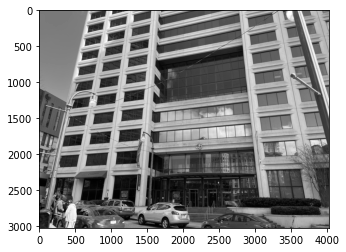

In [ ]:
#grey sclae conversion

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

img = mpimg.imread('/content/55parkplace_team2_1.png')

gray = rgb2gray(img)

plt.imshow(gray, cmap = plt.get_cmap('gray'))

plt.savefig('greyscaleimg.png')
plt.show()

In [ ]:
from PIL import Image

img = Image.open('/content/55parkplace_team2_1.png')
imgGray = img.convert('L')
imgGray.save('test_grayimg.png')

In [ ]:
#Import the image
img = cv2.imread('/content/test_grayimg.png', 1)
# define a function for box filter
def box_kernel(size):
  k = np.ones((size,size),np.float32)/(size**2)
  return k
# Basically, the smallest the kernel, the less visible is the blur. In our example, we will use a 5 by 5 kernel.
size=5
box_filter_img = cv2.filter2D(img,-1,box_kernel(size))

In [ ]:
# Define a function for box filter
def gaussian_kernel(size, sigma=1):
  size = int(size) // 2
  x, y = np.mgrid[-size:size+1, -size:size+1]
  normal = 1 / (2.0 * np.pi * sigma**2)
  g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
  return g
size=5
# Apply the gaussian blur
gaussian_filter_img = cv2.filter2D(img,-1,
                                   gaussian_kernel(size, sigma=1))

with kernel size: 3


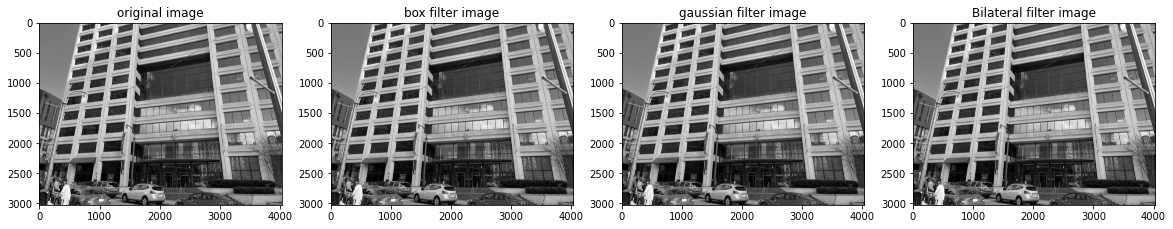

with kernel size: 11


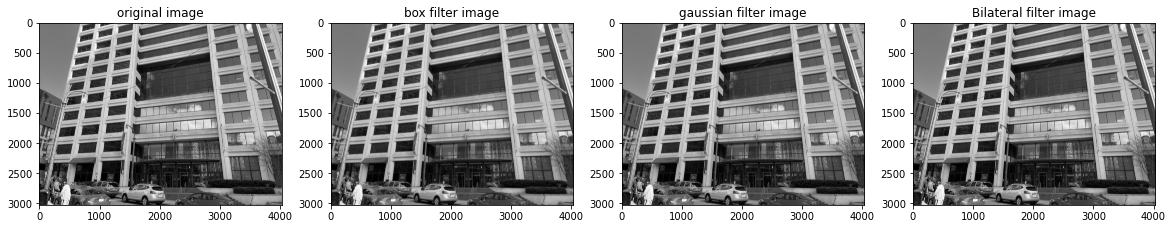

with kernel size: 19


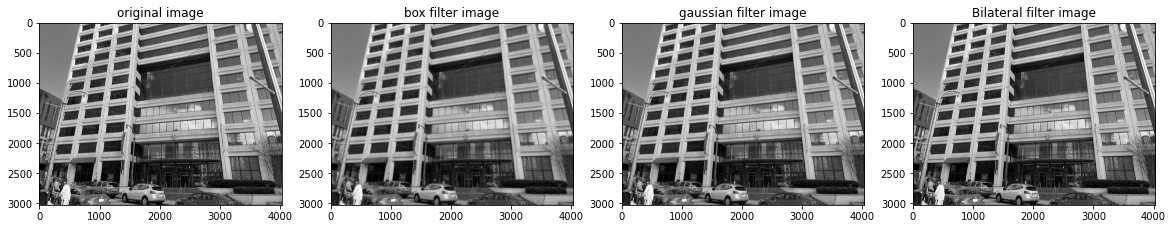

with kernel size: 27


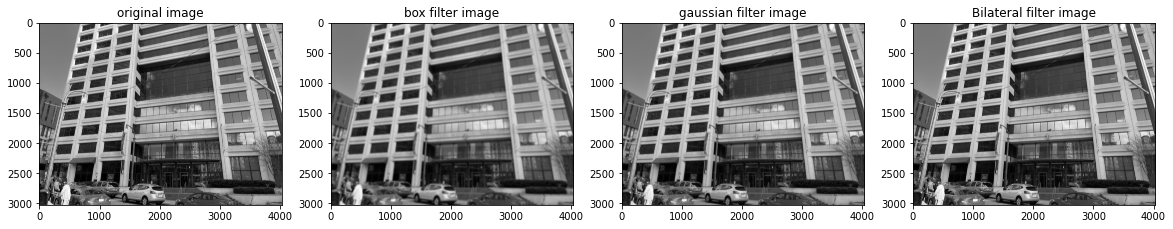

In [ ]:
# Define a function for plotting multiple figures
def plot_img(images, titles):
  fig, axs = plt.subplots(nrows = 1, ncols = len(images),
                          figsize = (20, 20))
  for i, p in enumerate(images):
    axs[i].imshow(cv2.cvtColor(p, cv2.COLOR_BGR2RGB))
    axs[i].set_title(titles[i])
    #axs[i].axis('off')
  plt.show()
# To show a side by side comparison of different filters with different kernel sizes.
for i in range(3,30,8):
  print("with kernel size: "+str(i))
  a_img = cv2.blur(img,(i,i))
  g_img = cv2.GaussianBlur(img,(i,i),0)
  b_img = cv2.bilateralFilter(img,i,75,75)
  images=[img, a_img, g_img, b_img]
  titles=['original image',
          'box filter image',
          'gaussian filter image',
          'Bilateral filter image']
  plot_img(images, titles)

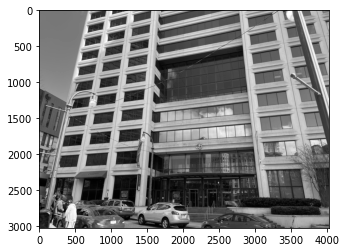

In [ ]:
img = imageio.imread("/content/test_grayimg.png")
img = img.astype('int32')
plt.imshow(img, cmap = plt.get_cmap('gray'))
plt.show()

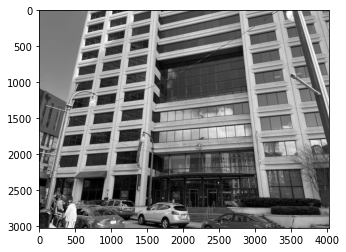

In [ ]:
# Blur the grayscale image so that only important edges are extracted and the noisy ones ignored
img_guassian_filter = ndimage.gaussian_filter(img, sigma=1) # sigma is taken as 1.4
plt.imshow(img_guassian_filter, cmap = plt.get_cmap('gray'))
plt.show()

In [ ]:
def SobelFilter(img, direction):
    if(direction == 'x'):
        Gx = np.array([[-1,0,+1], [-2,0,+2],  [-1,0,+1]])
        Res = ndimage.convolve(img, Gx)
        #Res = ndimage.convolve(img, Gx, mode='constant', cval=0.0)
    if(direction == 'y'):
        Gy = np.array([[-1,-2,-1], [0,0,0], [+1,+2,+1]])
        Res = ndimage.convolve(img, Gy)
        #Res = ndimage.convolve(img, Gy, mode='constant', cval=0.0)
    
    return Res
def Normalize(img):
    #img = np.multiply(img, 255 / np.max(img))
    img = img/np.max(img)
    return img

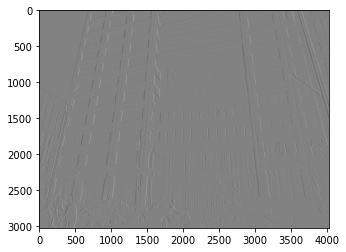

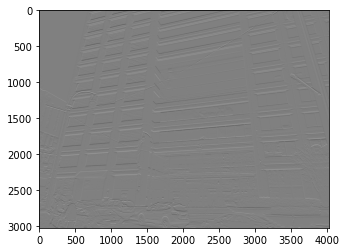

(3024, 4032)

In [ ]:
gx = SobelFilter(img_guassian_filter, 'x')
gx = Normalize(gx)
plt.imshow(gx, cmap = plt.get_cmap('gray'))
plt.show()
gy = SobelFilter(img_guassian_filter, 'y')
gy = Normalize(gy)
plt.imshow(gy, cmap = plt.get_cmap('gray'))
plt.show()
type(gx)
gx.shape


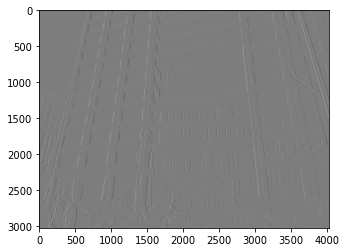

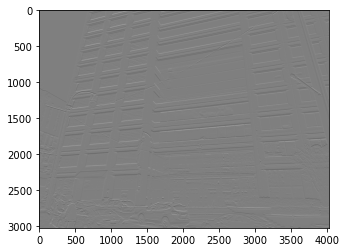

(3024, 4032)

In [ ]:
dx = ndimage.sobel(img_guassian_filter, axis=1) # horizontal derivative
plt.imshow(dx, cmap = plt.get_cmap('gray'))
plt.show()
dy = ndimage.sobel(img_guassian_filter, axis=0) # vertical derivative
plt.imshow(dy, cmap = plt.get_cmap('gray'))
plt.show()
type(dx)
dx.shape
dy.shape

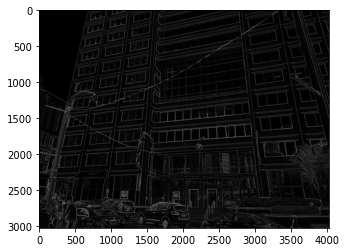

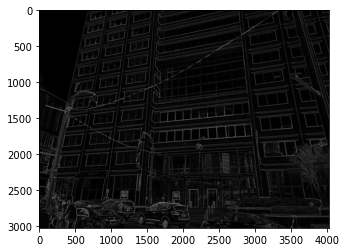

In [ ]:
Mag = np.hypot(gx,gy)
Mag.shape
plt.imshow(Mag, cmap = plt.get_cmap('gray'))
plt.show()
mag = np.hypot(dx,dy)
mag.shape
plt.imshow(mag, cmap = plt.get_cmap('gray'))
plt.show()

In [ ]:
Gradient = np.degrees(np.arctan2(gy,gx))
gradient = np.degrees(np.arctan2(dy,dx))

In [ ]:
def NonMaxSupWithInterpol(Gmag, Grad, Gx, Gy):
    NMS = np.zeros(Gmag.shape)
    
    for i in range(1, int(Gmag.shape[0]) - 1):
        for j in range(1, int(Gmag.shape[1]) - 1):
            if((Grad[i,j] >= 0 and Grad[i,j] <= 45) or (Grad[i,j] < -135 and Grad[i,j] >= -180)):
                yBot = np.array([Gmag[i,j+1], Gmag[i+1,j+1]])
                yTop = np.array([Gmag[i,j-1], Gmag[i-1,j-1]])
                x_est = np.absolute(Gy[i,j]/Gmag[i,j])
                if (Gmag[i,j] >= ((yBot[1]-yBot[0])*x_est+yBot[0]) and Gmag[i,j] >= ((yTop[1]-yTop[0])*x_est+yTop[0])):
                      NMS[i,j] = Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] > 45 and Grad[i,j] <= 90) or (Grad[i,j] < -90 and Grad[i,j] >= -135)):
                yBot = np.array([Gmag[i+1,j] ,Gmag[i+1,j+1]])
                yTop = np.array([Gmag[i-1,j] ,Gmag[i-1,j-1]])
                x_est = np.absolute(Gx[i,j]/Gmag[i,j])
                if (Gmag[i,j] >= ((yBot[1]-yBot[0])*x_est+yBot[0]) and Gmag[i,j] >= ((yTop[1]-yTop[0])*x_est+yTop[0])):
                    NMS[i,j] =Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] > 90 and Grad[i,j] <= 135) or (Grad[i,j] < -45 and Grad[i,j] >= -90)):
                yBot = np.array([Gmag[i+1,j] ,Gmag[i+1,j-1]])
                yTop = np.array([Gmag[i-1,j] ,Gmag[i-1,j+1]])
                x_est = np.absolute(Gx[i,j]/Gmag[i,j])
                if (Gmag[i,j] >= ((yBot[1]-yBot[0])*x_est+yBot[0]) and Gmag[i,j] >= ((yTop[1]-yTop[0])*x_est+yTop[0])):
                    NMS[i,j] =Gmag[i,j]
                else:
                    NMS[i,j] = 0
            if((Grad[i,j] > 135 and Grad[i,j] <= 180) or (Grad[i,j] < 0 and Grad[i,j] >= -45)):
                yBot = np.array([Gmag[i,j-1] ,Gmag[i+1,j-1]])
                yTop = np.array([Gmag[i,j+1] ,Gmag[i-1,j+1]])
                x_est = np.absolute(Gy[i,j]/Gmag[i,j])
                if (Gmag[i,j] >= ((yBot[1]-yBot[0])*x_est+yBot[0]) and Gmag[i,j] >= ((yTop[1]-yTop[0])*x_est+yTop[0])):
                    NMS[i,j] =Gmag[i,j]
                else:
                    NMS[i,j] = 0
    
    return NMS

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


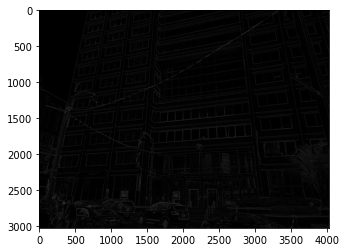

In [ ]:
NMS = NonMaxSupWithInterpol(mag, gradient, dx, dy)
NMS = Normalize(NMS)
plt.imshow(NMS, cmap = plt.get_cmap('gray'))
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


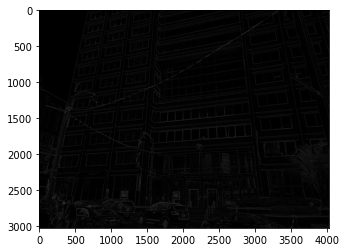

In [ ]:
nms = NonMaxSupWithInterpol(mag, gradient, dx, dy)
nms = Normalize(nms)
plt.imshow(nms, cmap = plt.get_cmap('gray'))
plt.show()

In [ ]:
# Double threshold Hysterisis
# Note that I have used a very slow iterative approach for ease of understanding, a faster implementation using recursion can be done instead
# This recursive approach would recurse through every strong edge and find all connected weak edges
def DoThreshHyst(img):
    highThresholdRatio =0.32
    lowThresholdRatio = 0.30
    GSup = np.copy(img)
    h = int(GSup.shape[0])
    w = int(GSup.shape[1])
    highThreshold = np.max(GSup) * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio    
    x = 0.1
    oldx=0
    
    # The while loop is used so that the loop will keep executing till the number of strong edges do not change, i.e all weak edges connected to strong edges have been found
#     while(oldx != x):
#         oldx = x
    for i in range(1,h-1):
        for j in range(1,w-1):
            if(GSup[i,j] > highThreshold):
                GSup[i,j] = 1
            elif(GSup[i,j] < lowThreshold):
                GSup[i,j] = 0
            else:
                if((GSup[i-1,j-1] > highThreshold) or 
                    (GSup[i-1,j] > highThreshold) or
                    (GSup[i-1,j+1] > highThreshold) or
                    (GSup[i,j-1] > highThreshold) or
                    (GSup[i,j+1] > highThreshold) or
                    (GSup[i+1,j-1] > highThreshold) or
                    (GSup[i+1,j] > highThreshold) or
                    (GSup[i+1,j+1] > highThreshold)):
                    GSup[i,j] = 1
#         x = np.sum(GSup == 1)
    
    GSup = (GSup == 1) * GSup # This is done to remove/clean all the weak edges which are not connected to strong edges
    
    return GSup

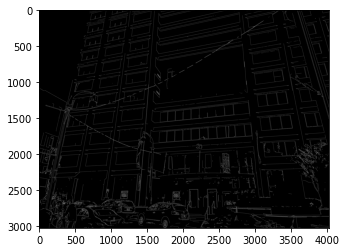

In [ ]:
Final_Image = DoThreshHyst(NMS)
plt.imshow(Final_Image, cmap = plt.get_cmap('gray'))
plt.show()